# Standard Backpropogation Algorithm

Hidden layer trained by backpropagation

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pandas as pd
import time

import os
import scipy as sp

import torch
import torch.nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
bank_df = pd.read_csv('/content/drive/MyDrive/Neural Computing Coursework/bank_data_preprocessed.csv')
bank_df

FileNotFoundError: ignored

Split the dataset into Train/Test (Using Correlation Matrix >0.1 Corr)

In [ ]:
X = torch.tensor(bank_df.drop(columns = {"RowNumber", "CustomerId", "CreditScore", "Tenure", "NumOfProducts", "HasCrCard", "EstimatedSalary", "Surname", "Geography", "Exited"}, axis = 1).values, dtype = torch.float)
y = torch.tensor(bank_df["Exited"].astype(np.float32))

In [ ]:
print(X.shape, y.shape)

torch.Size([10000, 5]) torch.Size([10000])


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

In [ ]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

In [ ]:
train_loader = DataLoader(train_data, shuffle = True, batch_size = 12)
test_loader = DataLoader(test_data, shuffle = True, batch_size = len(test_data.tensors[0]))

In [ ]:
print("Training data batches:")
#for X,y in train_loader:
#  print(X.shape, y.shape)

for X,y in test_loader:
  print(X.shape, y.shape)

Training data batches:
torch.Size([3000, 5]) torch.Size([3000])


In [ ]:
# #tensor_ = torch.from_numpy(df.to_numpy().astype(np.float32))
# tensor_X_train = torch.from_numpy(X_train.to_numpy().astype(np.float32))
# tensor_X_test = torch.from_numpy(X_test.to_numpy().astype(np.float32))
# tensor_y_train = torch.from_numpy(y_train.to_numpy().astype(np.float32))
# tensor_y_test = torch.from_numpy(y_test.to_numpy().astype(np.float32))


In [ ]:
test_loader

Creating Model

In [ ]:
import torch.nn as nn
class PoleNN(nn.Module):
  def __init__(self):
    super(PoleNN, self).__init__()
    # Modify the number of neurons in the hidden layer
    self.fc1 = nn.Linear(5, 8)
    self.fc2 = nn.Linear(8, 1)
    #Modify the activation functions
    self.sigmoid = torch.nn.Sigmoid()
    #self.relu = torch.nn.ReLU()
    #self.tanh = torch.nn.Tanh()
    #self.LeakyReLU

  def forward(self, x):
    hidden = self.fc1(x)
    hidden = self.sigmoid(hidden)
    output = self.fc2(hidden)
    return output

In [ ]:
pole_model = PoleNN()

Specifying our error loss function. We also have our optimizer where we can specify our learning rate.

In [ ]:
#Loss Function - changing the loss functions
criterion = torch.nn.MSELoss()
#criterion = torch.nn.L1Loss
#criterion = torch.nn.CrossEntropyLoss

In [ ]:
#Modify the learning rate
learning_rate = 0.25

In [ ]:
optimizer = torch.optim.SGD(pole_model.parameters(), lr = learning_rate)
#optimizer = torch.optim.Adam([var1, var2], lr=0.00001)

In [ ]:
pole_model.train()
num_epochs = 100
train_accuracies, test_accuracies = [], []
loss_list = []
epoch_list = []
accuracy_list = []
training_times = []

final_start_time = time.time()
for epoch in range(num_epochs):
    start_time = time.time()
    for X, y in train_loader:
      preds = pole_model(X)
      pred_labels = torch.argmax(preds, axis = 1)
      #y_pred = pole_model(X_train)
      loss = criterion(preds, y)
      #print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    end_time = time.time()
    epoch_time = end_time - start_time
    training_times.append(epoch_time)
    train_accuracies.append(
        100 * torch.mean((pred_labels == y).float()).item()
    )

    #correct += (y_pred == tensor_y_train).float().sum()

    #accuracy = 100 * correct / len(tensor_y_train)

#Test set - to find test accuracies
    X, y = next(iter(test_loader))

    pred_labels = torch.argmax(pole_model(X), axis=1)

    test_accuracies.append(
        100 * torch.mean((pred_labels == y).float()).item()
    )

# with torch.no_grad():
#     y_pred = pole_model(tensor_X_test)
#     predicted_labels = torch.argmax(y_pred, dim=1)
#     correct = (predicted_labels == tensor_y_test).sum().item()
#     accuracy = 100 * correct / len(tensor_y_test)
#     accuracy_list.append(accuracy)

    loss_list.append(loss.item())
    epoch_list.append(epoch)

final_end_time = time.time()
  #  print('Epoch {}: train loss: {}, test accuracy: {}%'.format(epoch, loss.item()))

final_time = final_end_time - final_start_time

In [ ]:
final_time

53.332656145095825

In [ ]:
len(training_times)

200

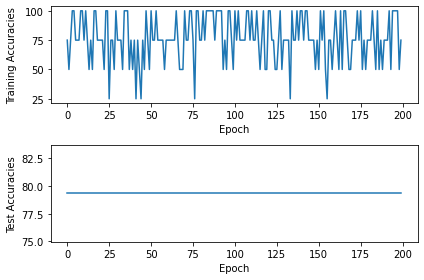

In [ ]:
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(nrows=2, ncols=1)

ax = fig.add_subplot(gs[0, 0])
ax.plot(train_accuracies)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Accuracies")

ax = fig.add_subplot(gs[1, 0])
ax.plot(test_accuracies)
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Accuracies")

fig.align_labels()
plt.show()

Text(0, 0.5, 'Training times')

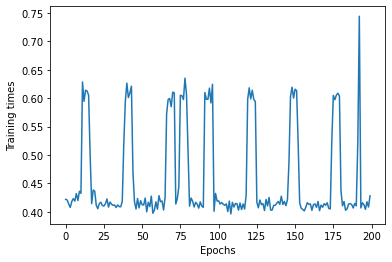

In [ ]:
plt.plot(epoch_list, training_times)
plt.xlabel("Epochs")
plt.ylabel("Training times")

Text(0, 0.5, 'Losses')

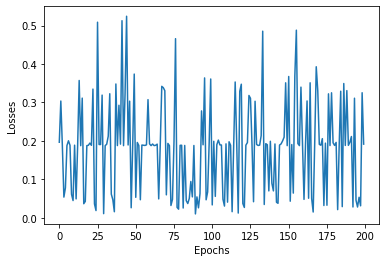

In [ ]:
plt.plot(epoch_list, loss_list)
plt.xlabel("Epochs")
plt.ylabel("Losses")

In [ ]:
def calc_error(mdl: torch.nn.Module, X: torch.Tensor, Y):
    # acc == (true != mdl(x).max(1).item() / true.size(0)
    train_acc = calc_accuracy(mdl, X, Y)
    train_err = 1.0 - train_acc
    return train_err

def calc_accuracy(mdl: torch.nn.Module, X: torch.Tensor, Y: torch.Tensor) -> float:
    """
    Get the accuracy with respect to the most likely label

    :param mdl:
    :param X:
    :param Y:
    :return:
    """
    # get the scores for each class (or logits)
    y_logits = mdl(X)  # unnormalized probs
    # return the values & indices with the largest value in the dimension where the scores for each class is
    # get the scores with largest values & their corresponding idx (so the class that is most likely)
    max_scores, max_idx_class = mdl(X).max(dim=1)  # [B, n_classes] -> [B], # get values & indices with the max vals in the dim with scores for each class/label
    # usually 0th coordinate is batch size
    n = X.size(0)
    assert( n == max_idx_class.size(0))
    # calulate acc (note .item() to do float division)
    acc = (max_idx_class == Y).sum().item() / n
    return acc


In [ ]:
calc_error(pole_model, X_train, y_train)

0.2024285714285714

In [ ]:
calc_accuracy(pole_model, X_test, y_test)

0.7933333333333333

In [ ]:
test_accuracies = [0.793]
#0.793 for learning rate 0.01, sigmoid activation function, 6 neurons in hidden layer
#      for learning rate 0.01, sigmoid activation function, 6 neurons in hidden layer